# Import libraries

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch
import random
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator


## Read data

In [112]:
song_data = pd.read_csv('tracks_features.csv',skiprows= (1, 20001), nrows=10000)
song_data.head ()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
1,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
2,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
3,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02
4,2LXPNLSMAauNJfnC58lSqY,Born of a Broken Man,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],6,1,False,0.298,...,0.0727,0.05380,0.001520,0.2010,0.194,148.282,280960,4.0,1999,1999-11-02


# 1. Data exploration

In [113]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  object 
 1   name              10000 non-null  object 
 2   album             10000 non-null  object 
 3   album_id          10000 non-null  object 
 4   artists           10000 non-null  object 
 5   artist_ids        10000 non-null  object 
 6   track_number      10000 non-null  int64  
 7   disc_number       10000 non-null  int64  
 8   explicit          10000 non-null  bool   
 9   danceability      10000 non-null  float64
 10  energy            10000 non-null  float64
 11  key               10000 non-null  int64  
 12  loudness          10000 non-null  float64
 13  mode              10000 non-null  int64  
 14  speechiness       10000 non-null  float64
 15  acousticness      10000 non-null  float64
 16  instrumentalness  10000 non-null  float64

In [114]:
song_data.describe()

,track_number,disc_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,7.107800,1.031200,0.507105,0.569278,5.22040,-10.899640,0.683100,0.090266,0.345835,0.236406,0.210774,0.457107,118.821395,2.475489e+05,3.853200,2001.522700
std,4.989456,0.234589,0.185304,0.282340,3.53987,6.396749,0.465291,0.129399,0.357262,0.354761,0.190384,0.266378,31.311599,1.689870e+05,0.541368,10.627981
min,1.000000,1.000000,0.000000,0.000000,0.00000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,0.000000,1949.000000
25%,3.000000,1.000000,0.380000,0.344000,2.00000,-13.640000,0.000000,0.034200,0.016500,0.000003,0.097400,0.232750,95.648250,1.804368e+05,4.000000,1996.000000
50%,6.000000,1.000000,0.520000,0.602000,5.00000,-9.327000,1.000000,0.044800,0.189500,0.002210,0.129000,0.451500,117.859000,2.287065e+05,4.000000,2001.000000
75%,10.000000,1.000000,0.641000,0.818000,8.00000,-6.416000,1.000000,0.076900,0.689250,0.510250,0.267250,0.673000,138.056250,2.825450e+05,4.000000,2008.000000
max,50.000000,5.000000,0.970000,1.000000,11.00000,3.802000,1.000000,0.962000,0.996000,1.000000,1.000000,0.984000,221.712000,6.054655e+06,5.000000,2020.000000


## 1.1. Check for missing values

In [115]:
song_data.isnull().sum()

id                  0
name                0
album               0
album_id            0
artists             0
artist_ids          0
track_number        0
disc_number         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
year                0
release_date        0
dtype: int64

## 1.2. Histogram of the data attributes

array([[<AxesSubplot: title={'center': 'track_number'}>,
        <AxesSubplot: title={'center': 'disc_number'}>,
        <AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>],
       [<AxesSubplot: title={'center': 'key'}>,
        <AxesSubplot: title={'center': 'loudness'}>,
        <AxesSubplot: title={'center': 'mode'}>,
        <AxesSubplot: title={'center': 'speechiness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'liveness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'duration_ms'}>,
        <AxesSubplot: title={'center': 'time_signature'}>,
        <AxesSubplot: title={'center': 'year'}>]], dtype=object)

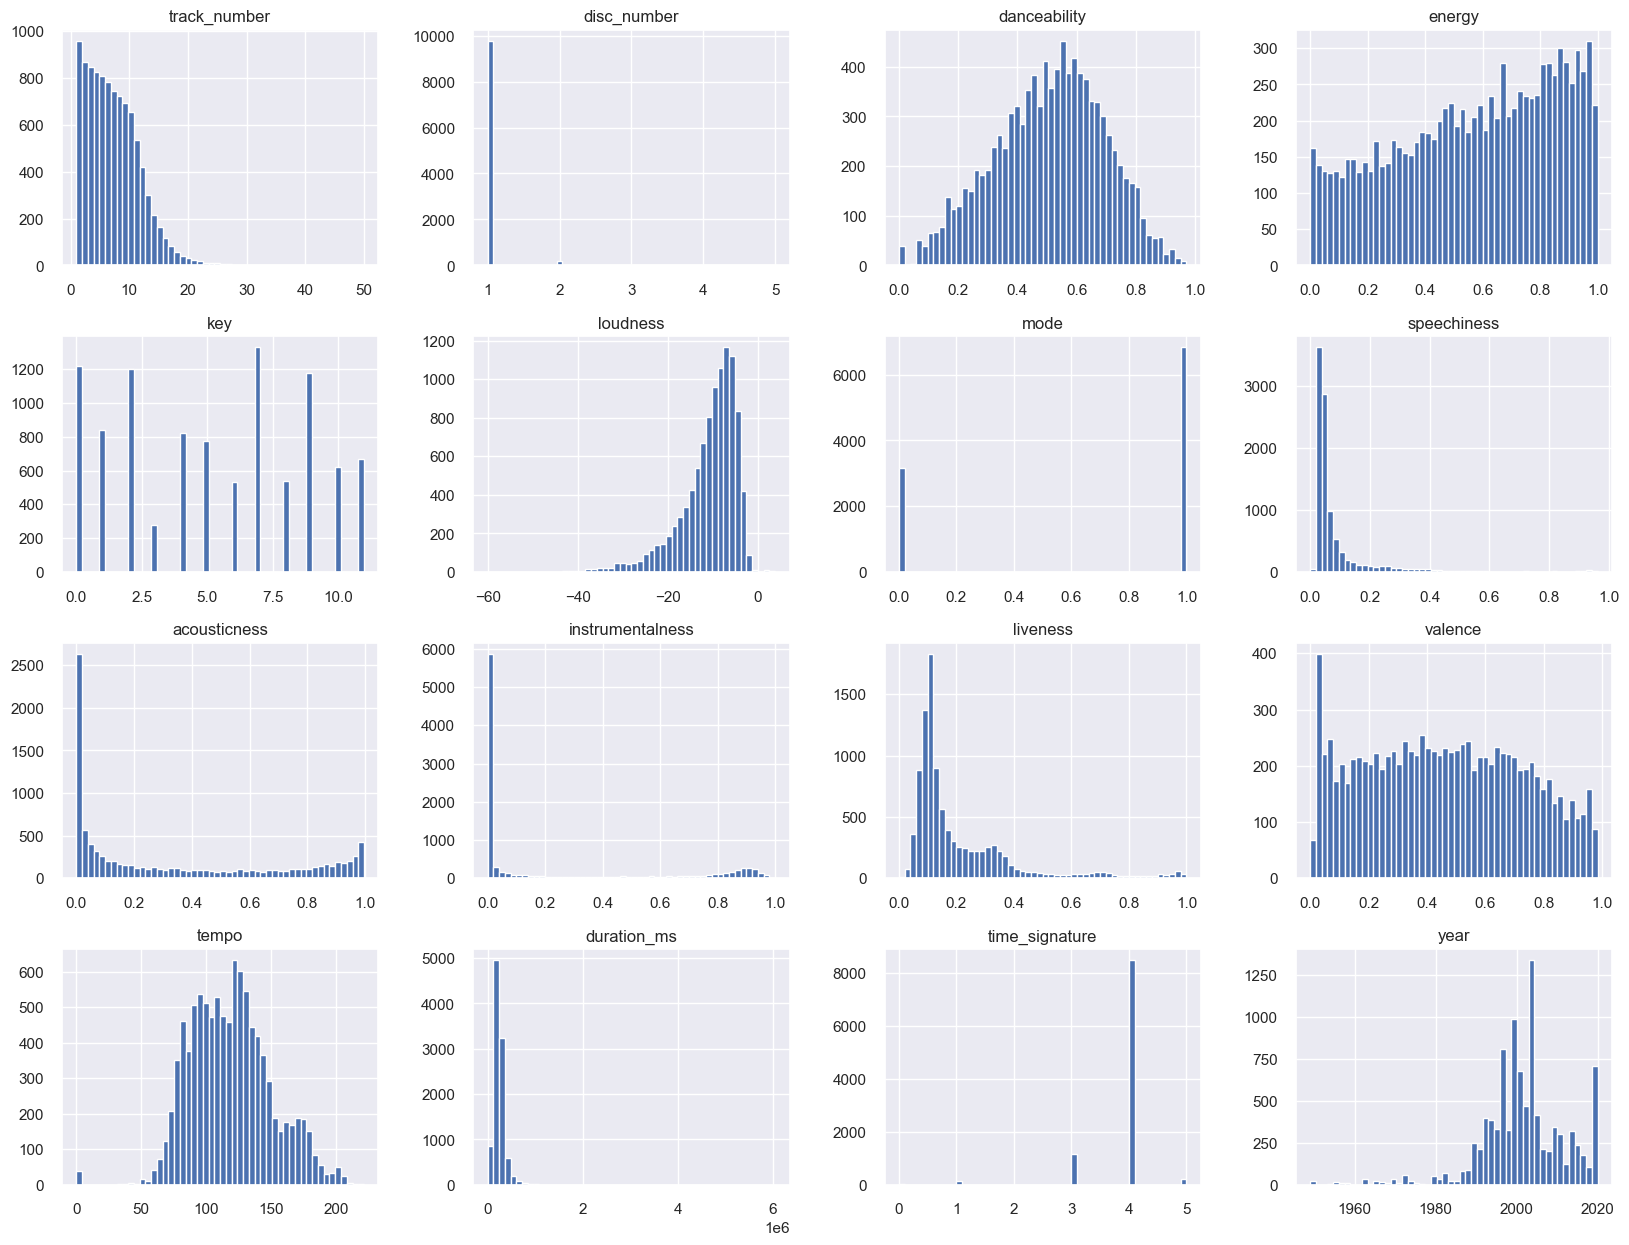

In [116]:
song_data.hist(bins=50, figsize=(20,15))

### Based on the histogram above, we choose "danceability" and "tempo" features because they are normal-distributed

## 1.3. Data normalization

In [117]:
columns_to_scale = ['danceability', 'tempo']
scaler = MinMaxScaler()
scaler.fit(song_data[columns_to_scale])
data_scaled = song_data.copy()
data_scaled[columns_to_scale] = scaler.transform(song_data[columns_to_scale])
X = data_scaled.iloc[:, [9,19]].values


## 1.4. Remove outliers based on z-scores

In [118]:
# Calculate Z-scores for each attribute
z_scores = np.abs((X - X.mean()) / X.std())

# Define a threshold for outlier detection 
threshold = 3

# Create a mask to identify outliers
outlier_mask = z_scores > threshold

# Remove outliers from the dataset
data_cleaned = X[~outlier_mask.any(axis=1)]

In [119]:
print("Original Dataset Size:", X.shape)
print("Cleaned Dataset Size:", data_cleaned.shape)

X = data_cleaned.copy()

Original Dataset Size: (10000, 2)
Cleaned Dataset Size: (9961, 2)


# 2. K-MEANS CLUSTERING

### 2.1. Apply elbow method to find the optimal number of clusters

In [120]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, n_init="auto", init = 'k-means++',random_state=41)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


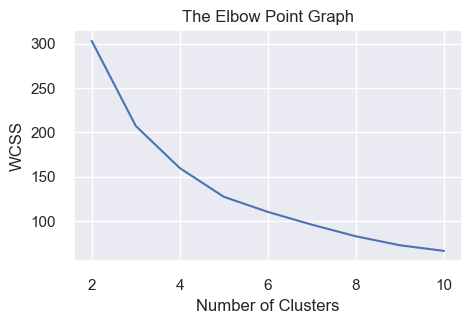

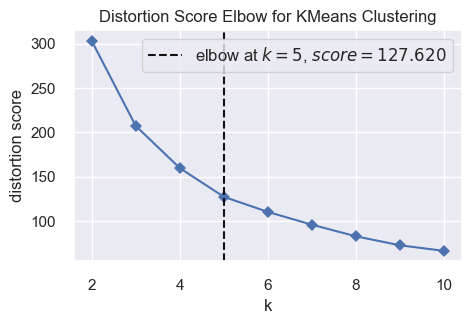

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [121]:
# plot an elbow graph
sns.set()
plt.plot(range(2,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,11), timings=False)
# Fit data to visualizer
visualizer.fit(X)
# Finalize and render figure
visualizer.show()

### 2.2. K-means clustering

In [122]:
kmeans = KMeans(n_clusters = visualizer.elbow_value_, n_init="auto", init = 'k-means++',random_state=41)

#return a label for each data point based on their cluster
Y_kmeans = kmeans.fit_predict(X)

print(Y_kmeans)

[1 0 2 3 0 2 0 2 2 3 2 3 2 1 2 0 3 0 3 3 3 1 1 1 1 1 1 1 1 3 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1 3 0 1 0 1 3 2 1 2 1 3 3 3 1 3 1 3 0 3 3 1 3 1 3 2 3 3 3 2
 3 0 1 1 3 1 1 3 1 1 3 2 3 0 2 0 0 0 2 3 3 3 3 3 1 3 3 1 1 0 1 1 1 1 1 3 2
 2 3 3 3 1 1 3 2 2 1 1 1 1 3 1 1 0 3 2 1 2 1 3 1 2 1 1 1 1 2 1 0 1 3 3 3 3
 2 3 3 3 2 1 3 3 2 3 1 3 1 1 0 1 3 2 0 2 2 2 3 0 2 2 0 2 2 2 3 2 2 2 2 3 1
 1 1 1 1 1 1 1 3 3 0 1 2 3 0 3 3 0 1 2 0 0 0 0 2 0 0 2 0 0 2 3 2 0 2 2 3 0
 0 2 2 2 3 1 1 1 1 1 1 0 1 1 1 3 1 1 3 1 1 1 1 2 1 1 1 1 3 3 3 3 0 2 2 1 3
 1 3 1 1 2 1 1 1 1 3 0 2 1 1 2 3 3 1 3 1 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 1 3 1 0 1 3 3 1 1 1 0 0 0 3 3 3 0 3 0 3 0 3 2 3 2 3 3 1 1 3 1 0 0 3 0
 0 2 3 0 1 3 1 0 0 3 2 0 2 1 0 3 0 0 1 3 0 1 3 2 3 1 2 3 3 1 3 1 0 2 3 3 3
 3 0 1 0 1 3 3 0 1 1 3 0 1 1 3 1 1 1 2 0 3 3 2 1 3 2 2 0 3 3 0 3 0 3 0 2 3
 2 2 3 1 2 1 2 2 3 2 2 2 2 0 2 0 2 2 0 1 3 1 1 1 3 1 3 3 3 1 3 2 2 1 1 1 2
 0 3 1 1 1 1 0 0 2 1 1 1 3 3 1 3 3 3 3 3 2 0 3 1 3 0 3 3 2 3 3 3 2 3 0 2 3
 3 2 3 1 1 2 1 1 0 3 3 3 

### 2.3. Visualizing the clusters

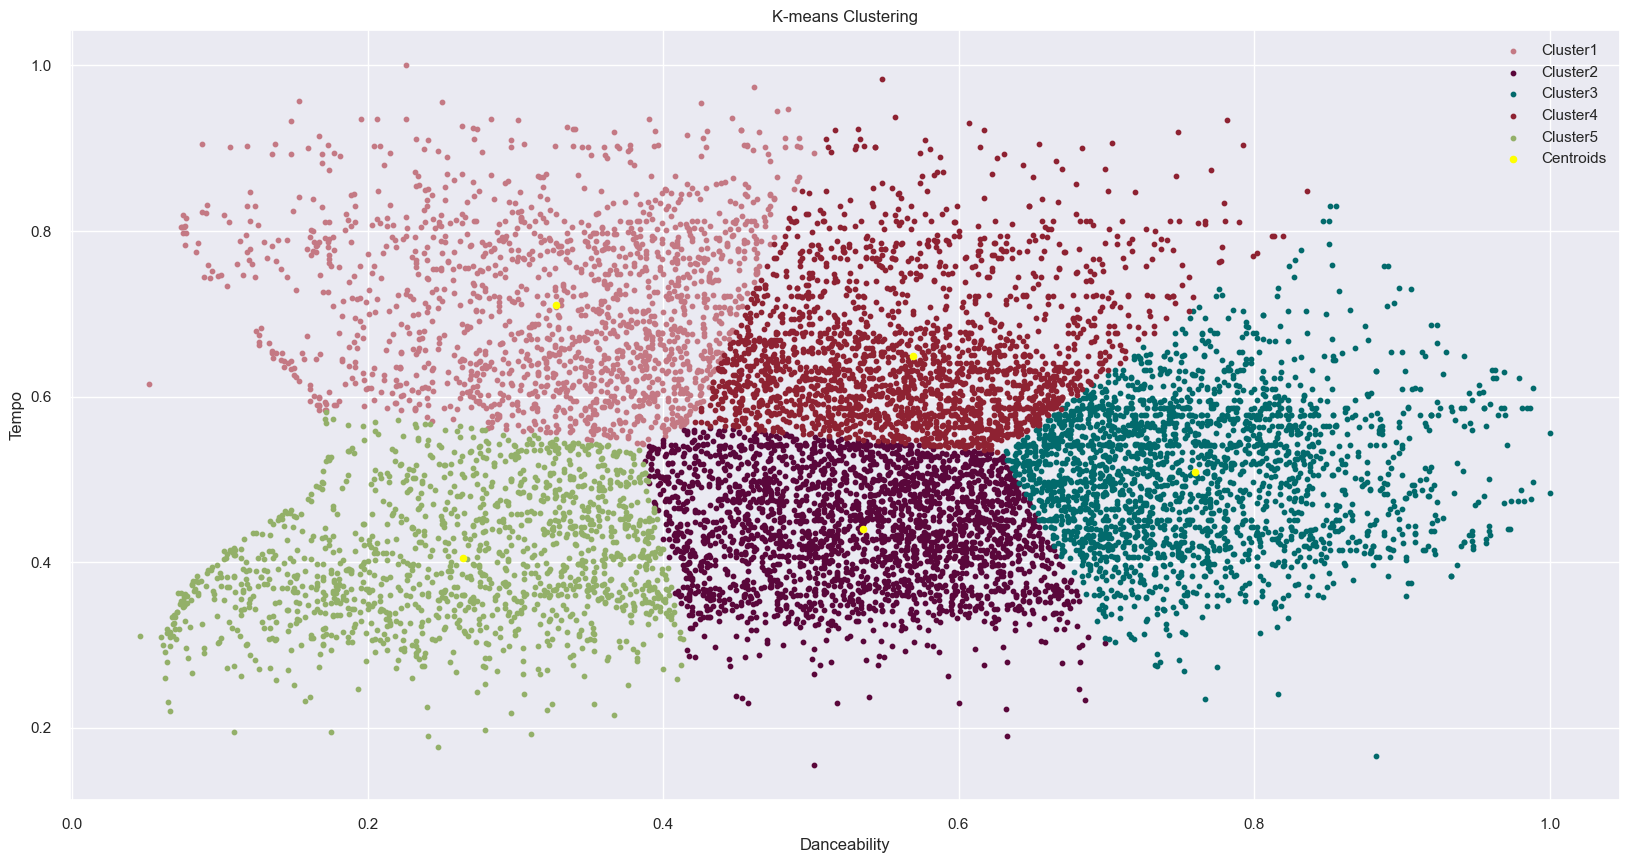

In [123]:
plt.figure(figsize=(20, 10))  

# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(visualizer.elbow_value_)]

for cluster_num in range(visualizer.elbow_value_):
    plt.scatter(X[Y_kmeans == cluster_num, 0], X[Y_kmeans == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')
plt.title('K-means Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

### 2.4. Evaluation

In [184]:
labels = kmeans.labels_
print("DAVIES BOULDIN score :", davies_bouldin_score(X, Y_kmeans))
print("SILHOUETTE score:", silhouette_score(X, Y_kmeans))

DAVIES BOULDIN score : 0.8505291339290799
SILHOUETTE score: 0.35198986896454687


# 3. HIERARCHICAL CLUSTERING

### 3.1. Dendrogram to select  the number of clusters

Text(0, 0.5, 'Euclidean distances')

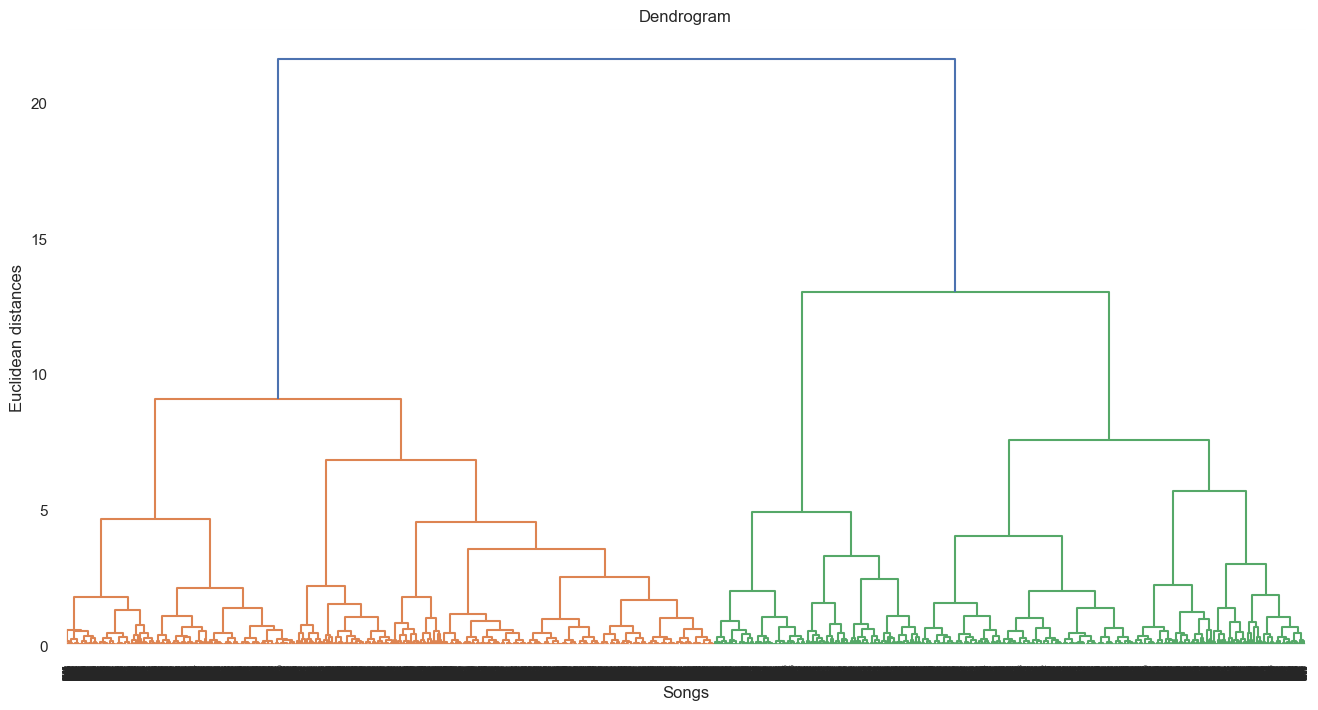

In [126]:
# graph size
plt.figure(1, figsize = (16 ,8))
# creating the dendrogram
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
# ploting graphabs
plt.title('Dendrogram')
plt.xlabel('Songs')
plt.ylabel('Euclidean distances')

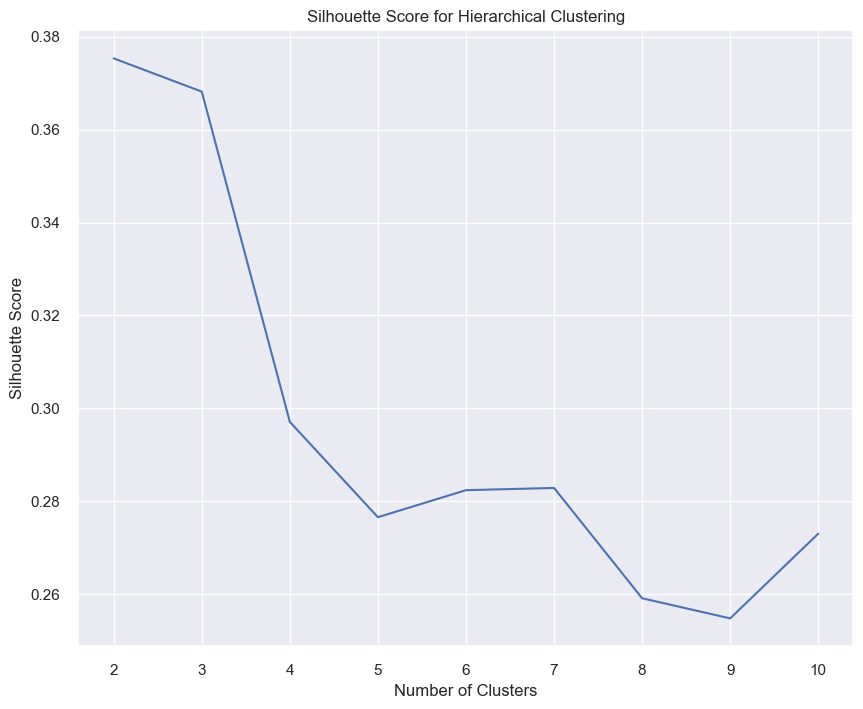

Optimal number of clusters: 2


In [127]:

# Range of cluster numbers to try
min_clusters = 2
max_clusters = 10

# Store silhouette scores
silhouette_scores = []

for n_clusters in range(min_clusters, max_clusters+1):
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, clustering.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10,8))
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.show()

# Find the optimal number of clusters
optimal_num_clusters = np.argmax(silhouette_scores) + min_clusters
print("Optimal number of clusters:", optimal_num_clusters)

### 3.2. Hierchical clustering

In [185]:
cluster = AgglomerativeClustering(n_clusters = optimal_num_clusters, metric = 'euclidean', linkage = 'ward')
Y_hierchical=cluster.fit_predict(X)
print(Y_hierchical)

[1 0 0 ... 0 0 0]


### 3.3. Visualizing the clusters

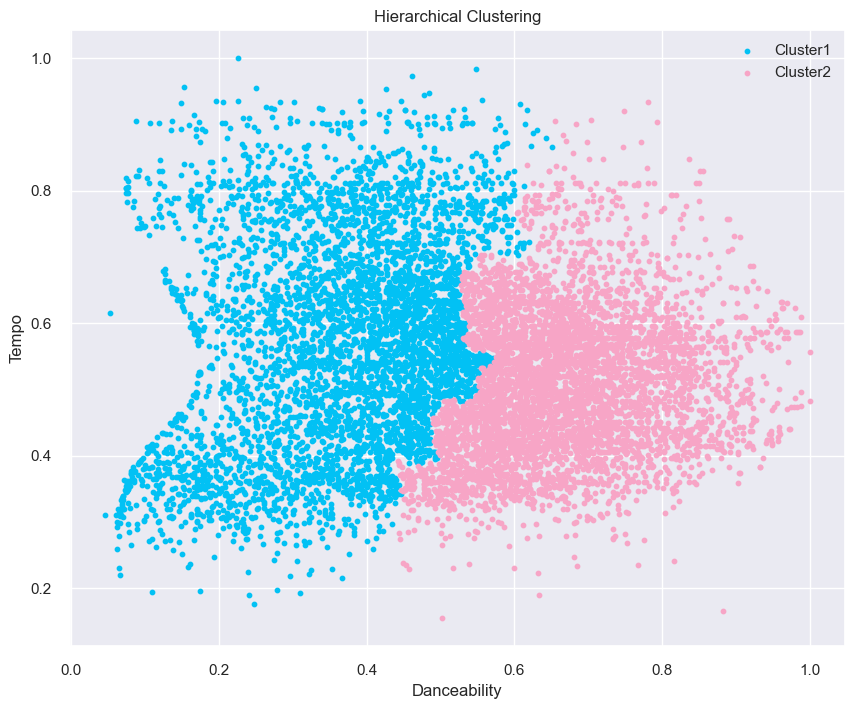

In [129]:
plt.figure(figsize=(10, 8))  

# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(optimal_num_clusters)]

for cluster_num in range(optimal_num_clusters):
    plt.scatter(X[Y_hierchical == cluster_num, 0], X[Y_hierchical == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')
plt.title('Hierarchical Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

### 3.4. Evaluation

In [186]:
davies_bouldin_avg = davies_bouldin_score(X, Y_hierchical)
print("DAVIES BOULDIN score:", davies_bouldin_avg)

silhouette_avg = silhouette_score(X, Y_hierchical)
print("SILHOUETTE score:", silhouette_avg)

DAVIES BOULDIN score: 1.028760117388843
SILHOUETTE score: 0.3753587828465461


# 4. DENSITY-BASED SCAN CLUSTERING

### 4.1. Calculate the parameters

In [188]:
no_neighbors = 4 # setting the number of neighbors
neighb = NearestNeighbors(n_neighbors=no_neighbors) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X) # finding the nearest neighbours

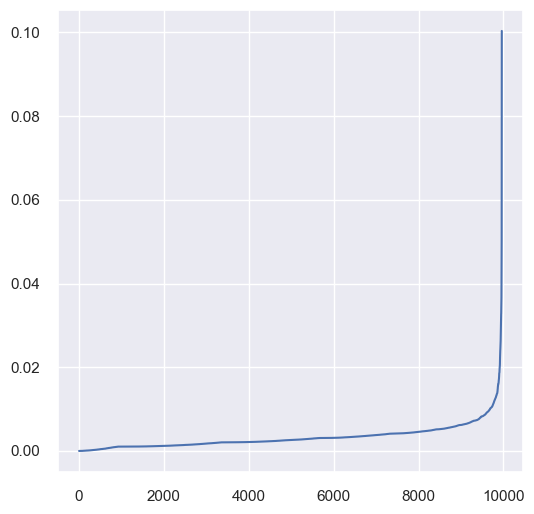

In [189]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.figure(figsize=(6,6))
# plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [190]:
plt.figure(figsize=(12,8))
kneedle = KneeLocator(x = range(1, len(distances)+1), y = distances, S = 1.0, curve = "concave", direction = "increasing", online=True)
# get the estimate of knee point
kneedle.knee_y

0.03335212712987554

<Figure size 1200x800 with 0 Axes>

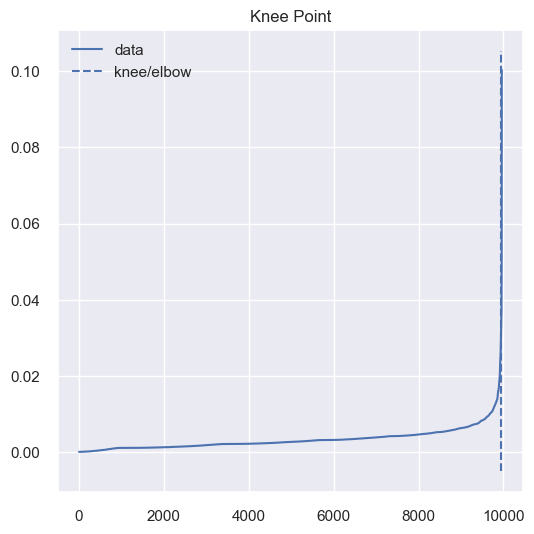

<Figure size 1200x800 with 0 Axes>

In [191]:
kneedle.plot_knee()
plt.figure(figsize=(12,8))
plt.show()

### 4.2. DBScan clustering

In [192]:
# cluster the data into five clusters
dbscan = DBSCAN(eps = kneedle.knee_y, min_samples = 4).fit(X) # fitting the model
Y_dbscan = dbscan.fit_predict(X) # getting the predicted values
labels = dbscan.labels_ # getting the labels
set(labels) # getting the unique labels


{-1, 0}

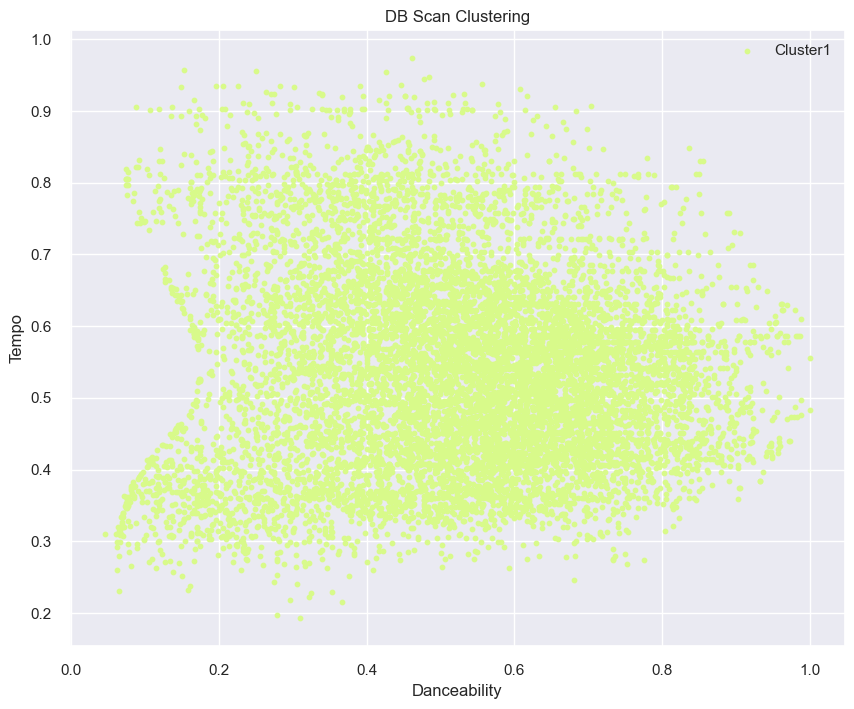

In [193]:
number_of_clusters = len(set(labels)) - 1

plt.figure(figsize=(10, 8))  
# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(number_of_clusters)]
for cluster_num in range(number_of_clusters):
    plt.scatter(X[Y_dbscan == cluster_num, 0], X[Y_dbscan == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')
plt.title('DB Scan Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

### 4.3. Evaluation

In [196]:
print("DAVIES BOULDIN score: ", davies_bouldin_score(X, labels))
print("SILHOUETTE score: ", silhouette_score(X, labels))

DAVIES BOULDIN score:  4.283496946296124
SILHOUETTE score:  0.36125778711418643
